In [369]:
### BH + Bulge (Hernquist profile) - Initial Conditions code for 'treecode' ### 

In [370]:
###################################################################################################################

In [371]:
## Section 1 - Creation of the initial condition file ## 

In [372]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Definition of the parameters of the system (in internal units)
Nparticles = 1000
Nbodies = Nparticles+1 # particles+BH
Ndimensions = 3
time = 0   # initial time simulation
r_scale = 10 # scale radius of the Hernquist's sphere 
M = 1   # total mass of the system
m = M/Nparticles # mass of each particle (equal mass particles)

# BH's initial conditions
M_BH = 0.1
x_BH = 0
y_BH = 0
z_BH = 0
vx_BH = 0
vy_BH = 0
vz_BH = 0

## Positions setting function
def positions(b):  
    # position of the particle in spherical coordinates
    k = np.random.random() # generation of a random number uniformly distributed in [0,1) 
    R = b*np.sqrt(k)*(1+np.sqrt(k))/(1-k)
    k = np.random.random()
    t = math.acos(1-(2*k))
    k = np.random.random()
    f = 2*(math.pi)*k 
    # position of the particle in cartesian coordinates
    x = R*(math.sin(t))*(math.cos(f))
    y = R*(math.sin(t))*(math.sin(f))
    z = R*(math.cos(t))
    return x,y,z,R,t,f

## Creation and filling of the position arrays
x = np.empty(Nparticles)
y = np.empty(Nparticles)
z = np.empty(Nparticles)

## Radius, theta, phi and q arrays are used in the next section to check if the initial conditions are correct
radius = np.empty(Nparticles)  
theta = np.empty(Nparticles)
phi = np.empty(Nparticles)

for i in range(Nparticles):
    x[i],y[i],z[i],radius[i],theta[i],phi[i] = positions(r_scale)

In [373]:
## Velocities Setting

In [374]:
## Hernquist density profile
def den_Hern(r,b,M):
    return M*b/(2*math.pi*r*(r+b)**3)

## Potential generated by the Hernquist density profile
def pot_Hern(r,b,M):
    return -M/(r+b)

## Potential generated by the BH
def pot_BH(r,MBH):
    return -MBH/r

## Total potential
def pot_tot(r,b,M,MBH):
    return (pot_Hern(r,b,M)+pot_BH(r,MBH))

## From the total potential to the radius
def inv_pot(pot,MBH,MH,b):
    delta = (b*pot-MBH-MH)**2+4*pot*b*MBH
    r = ( MBH+MH-b*pot+(delta)**(1/2) )/(2*pot)
    return r

## Integrand used to compute the distribution function 
def integrand(x,b,c):  # integra la prima variabibile data tra le parentesi (x)
    return c/(np.sqrt(b-x)*np.sqrt(8)*np.pi**2)

In [375]:
from scipy.integrate import quad
from scipy import interpolate

In [376]:
r_sort = np.sort(radius)
r_add = r_sort[0]-r_sort[0]/100 # radius added manually to r_sort in order to have f(eps) also for eps_max (otherwise I would have it up to eps_max-d(eps))
r_sort = np.insert(r_sort, 0, r_add)
e_max = -pot_tot(r_sort[0],r_scale,M,M_BH) # the nearest partcle sets the maximum relative potential energy (remember that eps = -E_tot)
e_min = -pot_tot(r_sort[-1],r_scale,M,M_BH) # the far away particle sets the minimum relative potential energy

In [377]:
k_points = 10000 # number of points used for the integral
eps_sliced = np.linspace(e_min,e_max,k_points) 

In [378]:
# for the derivative d(rho)/d(psi)
r_sliced = inv_pot(eps_sliced,M_BH,M,r_scale) # NB: it's sorted in descending order

density_sliced = den_Hern(r_sliced,r_scale,M)
relPot_sliced = eps_sliced

delta_den = np.diff(density_sliced)
delta_relPot = np.diff(relPot_sliced)
den_relPot = delta_den/delta_relPot

In [379]:
# Computation of the area
area_intervals=[]
first_deriv = (den_Hern(r_sliced[0],r_scale,M)-0)/(eps_sliced[0]-0)
area_intervals.append( quad(integrand,0,eps_sliced[0],args=(eps_sliced[0], first_deriv ))[0] )
for i in range(len(eps_sliced)-1):
    integral = quad(integrand,0,eps_sliced[i+1],args=(eps_sliced[i+1],den_relPot[i]))[0]
    area_intervals.append( integral )

In [380]:
# Computation of the derivative
delta_area = np.diff(area_intervals)
delta_area = np.insert(delta_area,0,area_intervals[0])
eps_sliced = np.insert(eps_sliced, 0, 0)
delta_eps = np.diff(eps_sliced)
derivative = delta_area/delta_eps

In [381]:
eps_sliced = np.delete(eps_sliced,len(eps_sliced)-1) # I delete eps added for the added R

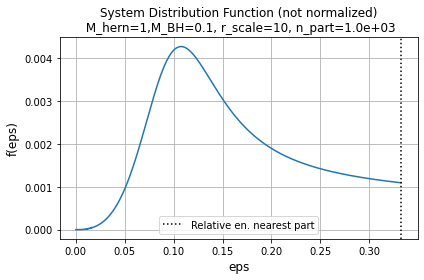

In [382]:
plt.plot(eps_sliced,derivative)
plt.axvline(eps_sliced[-1],label='Relative en. nearest part',c='k',ls=':')
plt.xlabel('eps',fontsize=12)
plt.ylabel('f(eps)',fontsize=12)
plt.title('System Distribution Function (not normalized)\n M_hern={},M_BH={}, r_scale={}, n_part={:3.1e}'.format(M,M_BH,r_scale,Nparticles))
plt.grid()
plt.legend()
plt.tight_layout()
plt.savefig('Distribution_function.jpg')

In [383]:
# Spline interpolation of the nearest particle's pdf (in way way we have the spline data for each particle)
spline_data = interpolate.splrep(eps_sliced, derivative, s=0) # spline interpolation of the whole data

# N.B. The spline maybe oscillates, between two given interpolation points, in an undesired way (in particular at the
# edges): to avoid this, increase the number of points used to do the above integral
# WARNING: the spline oscillations may caused some problem in the computation of the velocities; indeed, to compute
# them we use the spline interpolation and to find the velocity in function of the cdf we interpolate y vs x.
# This is not the smartest approach, because in practice, if the spline oscillates between two points, it could happen
# that the f_mean used to compute the velocity (see below) can be negative and so the area for that bin is and so
# the cumulative function will not be monotonically increasing and so the spline interpolation (y vs x) obviously
# fails. To avoid this, increase the number of points used in the computation of the mean or the number of points
# used to commpute the integral or, better, change the code (interpolate x vs y and than write the code to extract
# v_mod from that)

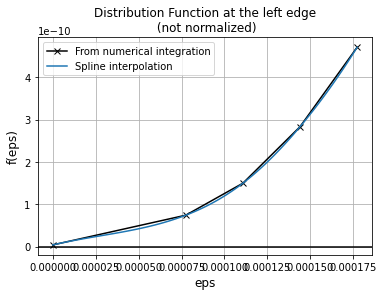

In [384]:
# Check if the spline interpolation oscillates to much at the left edge (look at the scale of the y axis
# to have an idea of the oscillation value)

xnew = np.linspace(0, eps_sliced[4], 100) # I consider a particle near to the left edge (eps=0)
ynew = interpolate.splev(xnew, spline_data, der=0)

plt.plot(eps_sliced[eps_sliced<=eps_sliced[4]],derivative[eps_sliced<=eps_sliced[4]],label='From numerical integration',marker='x',color='k')

plt.plot(xnew,ynew,label='Spline interpolation')
plt.xlabel('eps',fontsize=12)
plt.ylabel('f(eps)',fontsize=12)
plt.title('Distribution Function at the left edge\n (not normalized)')
plt.axhline(0,c='k',ls='-')
plt.grid()
plt.legend()

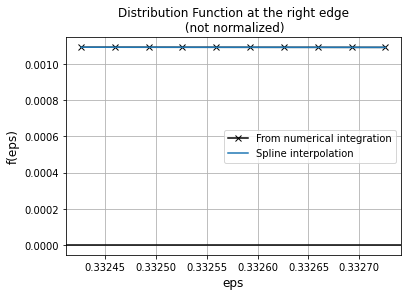

In [385]:
# Check if the spline interpolation oscillates to much at the right edge (look at the scale of the y axis
# to have an idea of the oscillation value). It's recommended to avoid oscillations under the value zero,
# otherwise in the computation of the velocities, f_mean in those intervals can be less than zero and this
# can cause problem (see below)

xnew = np.linspace(eps_sliced[-10], eps_sliced[-1], 100) # I consider a particle near to the left edge (eps=0)
ynew = interpolate.splev(xnew, spline_data, der=0)

plt.plot(eps_sliced[eps_sliced>=eps_sliced[-10]],derivative[eps_sliced>=eps_sliced[-10]],label='From numerical integration',marker='x',color='k')

plt.plot(xnew,ynew,label='Spline interpolation')
plt.xlabel('eps',fontsize=12)
plt.ylabel('f(eps)',fontsize=12)
plt.title('Distribution Function at the right edge\n (not normalized)')
plt.axhline(0,c='k',ls='-')
plt.grid()
plt.legend()

In [386]:
## If you are satisfied of the interpolation, you can proceed with the computation of the velocities, otherwise
## change the number of points used to compute the integral above

#  computational time expected to set the velocities: N=1'000 t=22sec, N=10'000 t=224sec

In [387]:
vx = np.empty(Nparticles)
vy = np.empty(Nparticles)
vz = np.empty(Nparticles)

In [388]:
for i_particle in range(Nparticles):
    particle_relPot = -pot_tot(radius[i_particle],r_scale,M,M_BH) # Max energy of the particle
    v_max = np.sqrt(2*particle_relPot)
    particle_pdf = derivative[eps_sliced<=particle_relPot]  # selection of the distribution function's points for this particle
    eps_sliced_part = eps_sliced[eps_sliced<=particle_relPot] # abscissa of the selected particle's pdf
    k_points = 100 # cdf's sample points 
    v_sliced = np.linspace(0,v_max,k_points)
    delta_v = np.diff(v_sliced)
    A = [] # used to compute the cumulative sum
    for i in range(len(v_sliced)-1):
        k = 1000 # points used to compute the mean
        points_v = np.linspace(v_sliced[i],v_sliced[i+1],k)
        u = particle_relPot-0.5*v_sliced[i]**2 # upper limit for the pdf
        l = particle_relPot-0.5*v_sliced[i+1]**2 # lower limit for the pdf
        points_f = np.linspace(l,u,k)
        mean_vSquare = np.mean( points_v**2 )  
        f_values = interpolate.splev(points_f, spline_data, der=0)
        mean_f = np.mean( f_values )
        A.append( delta_v[i]*mean_f*mean_vSquare )
    cum =  np.cumsum(A)
    particle_cdf = cum/cum[-1]  
    particle_cdf = np.insert(particle_cdf, 0, 0)
    spline_data_cdf = interpolate.splrep(particle_cdf,v_sliced, s=0) # interpolation of the inverse of the cdf 
    ## Extraction of the velocity from the cdf
    k = np.random.random()
    vmod = k*interpolate.splev(k, spline_data_cdf, der=0) # modulo of the velocity
    # spherical distribution in the velocities: theta and phi distributed in such a way
    k = np.random.random()
    t = math.acos(1-(2*k))
    k = np.random.random()
    f = 2*(math.pi)*k 
    # velocity of the particle in cartesian coordinates
    vx[i_particle] = vmod*(math.sin(t))*(math.cos(f))
    vy[i_particle] = vmod*(math.sin(t))*(math.sin(f))
    vz[i_particle] = vmod*(math.cos(t))

In [389]:
## We are studying a system with a BH at the center. In order to have a nice resolution of the BH is necessary
## to populate with a non negligible percentage of particles the BH's sphere of influence. If you have populated
## the sphere of influence with too low particles, change the number of particles or the mass of the BH (a small
## mass will result in a small radius of influence)
v_mod = (vx**2+vy**2+vz**2)**(1/2)
v_mean =np.mean(v_mod)
dispersion_vel = np.sum( (v_mod-v_mean)**2 )
dispersion_vel = dispersion_vel/Nparticles
influence_radius = M_BH/dispersion_vel
particles_in = len(r_sort[r_sort<=influence_radius]) # number of particles within the influence radius of the BH
print('Tot. number of particles: {}\nNumber of particles within the influence radius: {} ({}%)'.format(Nparticles,particles_in,100*particles_in/Nparticles))

Tot. number of particles: 1000
Number of particles within the influence radius: 372 (37.2%)


In [390]:
## If the percentage of particles in the influence sphere is ok, proceed

In [391]:
## Saving the initial conditions in 'initial_conditions_file.txt' that then will be runned by the c++ code
with open('initial_conditions_file.txt','w') as file:
    file.write("{}\n{}\n{}\n".format(Nbodies,Ndimensions,time))
    file.write("{}\n".format(M_BH))
    for i in range(Nparticles):
        file.write("{}\n".format(m))        
    file.write("{:25.15e}{:25.15e}{:25.15e}\n".format(x_BH,y_BH,z_BH))
    for i in range(Nparticles):
        file.write("{:25.15e}{:25.15e}{:25.15e}\n".format(x[i],y[i],z[i]))
    file.write("{:25.15e}{:25.15e}{:25.15e}\n".format(vx_BH,vy_BH,vz_BH))     
    for i in range(Nparticles):
        file.write("{:25.15e}{:25.15e}{:25.15e}\n".format(vx[i],vy[i],vz[i]))  
## Saving some system's parameters used during the analysis section
with open('system_properties.txt','w') as file:
    file.write("{}\n{}\n{}\n{}\n".format(Nbodies,M,M_BH,r_scale))

In [392]:
## Dispersion velocity vs Radius

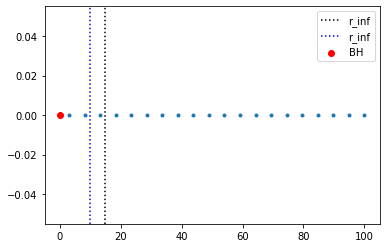

In [393]:
k = 20 # I divide the radius into 10
radius_sampled = np.linspace(influence_radius/5,r_scale*10,k)
plt.plot(radius_sampled,np.zeros(len(radius_sampled)),'.')
plt.axvline(influence_radius,c='k',ls=':',label='r_inf')
plt.axvline(r_scale,c='b',ls=':',label='r_inf')
plt.scatter(0,0,c='r',label='BH')
plt.legend()

In [394]:
dispersion_vel_vector = [] # N.B.I'm not deleting the one already calculated above
for i_interval in range(len(radius_sampled)):
    a = vx[radius<=radius_sampled[i_interval]]
    b = vy[radius<=radius_sampled[i_interval]]
    c = vz[radius<=radius_sampled[i_interval]]
    v_mod = (a**2+b**2+c**2)**(1/2)
    v_mean =np.mean(v_mod)
    d = np.sum( (v_mod-v_mean)**2/len(a) )
    dispersion_vel_vector.append( d ) # len(a)-->number of particles considered (I could have used b,c)

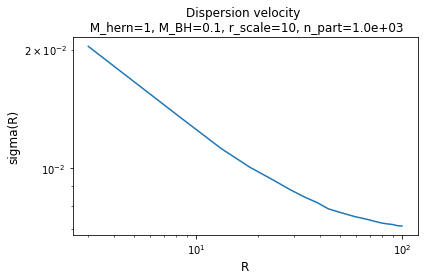

In [395]:
plt.plot(radius_sampled,dispersion_vel_vector)
plt.xlabel('R',fontsize=12)
plt.ylabel('sigma(R)',fontsize=12)
plt.title('Dispersion velocity \n M_hern={}, M_BH={}, r_scale={}, n_part={:3.1e}'.format(M,M_BH,r_scale,Nparticles,k_points))
plt.xscale('log')
plt.yscale('log')
plt.tight_layout()

In [396]:
###################################################################################################################

In [397]:
## Section 2 - Instruction to compile the code from the 'treecode' from the terminal and hints to set the parameters ##

In [398]:
# When you have runned 'Section 1', your system initial conditions will be saved in 'initial_conditions_file.txt';
# than, before running the 'Plummer's Sphere Stability - Analysis code', you need to run from 
# the terminal the c++ executable file. You can write (for example):
#
#   ./treecode in=initial_conditions_file.txt out=output_data.txt dtime=0.0005 eps=0.03 theta=0.1 options=out-phi tstop=0.5 dtout=0.05 > system_description.txt
#
# All the parameters are expressed in internal units; it's useful to compute the dynamical time of the system:

t_dynamical = r_scale/(M/r_scale)**(1/2)

# Here you can find the description of some of the parameters passed through the terminal (see for more details
# the documentation of the 'Barnes tree code' - http://www.ifa.hawaii.edu/faculty/barnes/treecode/treeguide.html):
# 
# - dtime: it is the integration time step. Set it not too big and too small; for example choose dtime=t_dynamical/(10^a)
#   It's convenient to use a timestep which has an exact representation as a floating-point number

dtime = t_dynamical/(10**2)

# - eps: it is the smoothing length used in the gravitational force calculation.
#  Here we divided the sphere in shells, computed the particles' mean distance in each shell and selected the 
#  smallest one. In this simulation we are dealing with a BH at the center: it's necessary to resolute its sphere
#  of influence and so eps must be less than the BH's influence radius. Then, we select the smallest value
#  between the BH's influence radius and the minimum mean distance. eps is a fraction of this selected value.
#  Note that a Black Hole of a small mass implies a small softening parameter and so the computational time increases.

counts, bin_edges = np.histogram(radius, bins='auto')
MeanSeparation = []
for i in range(len(counts)):
    if counts[i]!=0:
        MeanSeparation.append( ((4/3*math.pi*(bin_edges[i+1]**3-bin_edges[i]**3))/counts[i])**(1/3))
MinMeanSeparation = min(MeanSeparation)
minimum = min(MinMeanSeparation,influence_radius)
eps = minimum/10

# - theta: it is the opening angle used to adjust the accuracy of the force calculation. 
#  Values less than unity produce more accurate forces, albeit at greater computational expense.

theta_coeff = 0.1 # named in this way otherwise it overwrites the theta vector saved at the beginning

# - options=out-phi: it saves in the output_data.txt also the potential energy

# - tstop: it is the time at which the N-Body integration terminates. Set it, for example, as tstop=2*t_dynamical

tstop = 2*t_dynamical

# - dtout: it is the time interval between output files. To insure that outputs are performed when expected, dtout
# should be a multiple of dtime. The number of snapshots depends on 'dtout': the less its value is, the more number
# of outputs you'll have. A greater number of snapshots will be useful during the analysis because you'll have
# more information about the system but the computational cost of the analysis will be increased.

dtout = dtime*3

Nsnapshots = int(tstop/dtout)

In [399]:
print('\ndtime: ',dtime)
print('\nMean separation: {}, Influence radius: {}, eps: {}'.format(MinMeanSeparation,influence_radius,eps))
print('\ntheta: ', theta_coeff)
print('\ntstop: ', tstop)
print('\ndtout: ', dtout)
print('\nNsnaphots: ', Nsnapshots)


dtime:  0.31622776601683794

Mean separation: 2.5940508760422776, Influence radius: 14.966872896927711, eps: 0.25940508760422776

theta:  0.1

tstop:  63.245553203367585

dtout:  0.9486832980505138

Nsnaphots:  66


In [400]:
###################################################################################################################

In [401]:
## Section 3 - Check of the Initial Conditions ##

In [402]:
# For more details about the statistics and what is done here, see the similar section in the Analysis Code.
# Before evolving the system, it's recommended to check the initial conditions: this can done directly in the 
# analysis code (choosing the variable 'snapshot_to_check = 0'); however, for computational costs, we recommend 
# to do it here (indeed here we have already the R, theta, phi and q arrays; in the analysis code they have to be
# recomputed)

In [403]:
from scipy.stats import chisquare

In [404]:
## Radius Distribution

In [405]:
## pdf and cdf of the radial positions 
def pdf_r(b,r):
    return 2*b*r/(r+b)**3
def cdf_r(b,r):
    return 1-(b**2+2*b*r)/(r+b)**2

In [406]:
# Chisquare Section #
empirical,edges = np.histogram(radius,bins='auto')
counts = np.copy(empirical) # used in the histogram section
theorical = []
for i_bin in range(len(empirical)):
    if empirical[i_bin]>9:
        prob = cdf_r(r_scale,edges[i_bin+1]) - cdf_r(r_scale,edges[i_bin])
        theorical.append(prob*Nparticles)        
empirical = empirical[empirical>9] 

sta, pvalue = chisquare(empirical,theorical)
if pvalue>=0.05: print('pvalue: {}, test superato'.format(pvalue))
else: print('pvalue: {}, test non superato'.format(pvalue))

pvalue: 0.8959775478847297, test superato


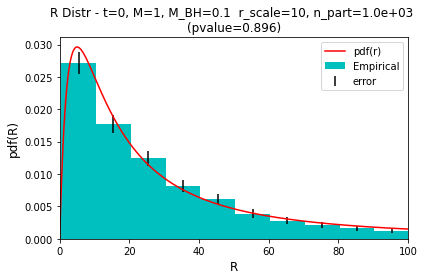

In [407]:
# Histogram Section #

# Generation of the normalized histogram and of the error bars
area = sum(np.diff(edges)*counts)
error = np.sqrt(counts) # Poissonian errors
bincenters = 0.5*(edges[1:]+edges[:-1])

normalized_counts_r, bin_edges_r, hist_r = plt.hist(radius,bins='auto',range=None,density=True,color='c',label='Empirical')
                                    # the bins selection is made through the 'auto' mode: maximum number of
                                    # bins between the 'Freedman–Diaconis rule' or the 'Sturge’s Rule' computation

error = np.divide(error, area) # the error bar must be rescaled since we normalized the histogram 
plt.errorbar(bincenters,normalized_counts_r,yerr=error,fmt='none',label='error',color='k')

## generation of the arrays containing some pdf's points
left_range = 0
right_range = r_scale*10
radius_pdf = np.empty(1000)
ascissa = np.linspace(left_range,right_range,1000)     
radius_pdf = pdf_r(r_scale,ascissa) 

plt.plot(ascissa,radius_pdf,color='r',label='pdf(r)')
plt.xlim(left_range,right_range)
plt.xlabel('R',fontsize=12)
plt.ylabel('pdf(R)',fontsize=12)
plt.title('R Distr - t=0, M={}, M_BH={}  r_scale={}, n_part={:3.1e} \n(pvalue={:3.3})'.format(M,M_BH,r_scale,Nparticles,pvalue))
plt.legend()
plt.tight_layout()
plt.savefig('R_histo.jpg') 
# N.B. if you change the scale radius or if you want to see the whole histogram, you need to do a manual rescale

In [408]:
## Phi Distribution

In [409]:
## pdf and cdf of the phi angle
def pdf_p():
    return (2*math.pi)**(-1)
def cdf_p(p):
    return p*(2*math.pi)**(-1)

In [410]:
# Chisquare Section #
empirical,edges = np.histogram(phi,bins='auto')
counts = np.copy(empirical) # used in the Histogram Section
theorical = []
for i_bin in range(len(empirical)):
    if empirical[i_bin]>9:
        prob = cdf_p(edges[i_bin+1]) - cdf_p(edges[i_bin])
        theorical.append(prob*Nparticles)        
empirical = empirical[empirical>9] 

sta, pvalue = chisquare(empirical,theorical)
if pvalue>=0.05: print('pvalue: {}, test superato'.format(pvalue))
else: print('pvalue: {}, test non superato'.format(pvalue))

pvalue: 0.9593153034195494, test superato


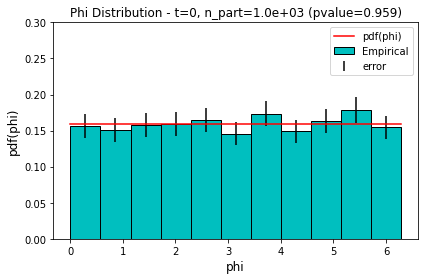

In [411]:
# Histogram Section #

# Generation of the normalized histogram and of the error bars
area = sum(np.diff(edges)*counts)
error = np.sqrt(counts) # Poissonian errors
bincenters = 0.5*(edges[1:]+edges[:-1])

normalized_counts_p, Bin_edges_p, hist_p = plt.hist(phi,bins='auto',range=None,density=True,color='c',edgecolor='black',label='Empirical')
error = error/area # the error bar must be rescaled since we normalized the histogram 
plt.errorbar(bincenters,normalized_counts_p,yerr=error,fmt='none',label='error',color='k')

## generation of the arrays containing some pdf's points
phi_pdf = np.empty(10)
ascissa = np.linspace(0,2*math.pi,10)
phi_pdf = np.ones(10)*pdf_p()        
        
plt.plot(ascissa,phi_pdf,color='r',label='pdf(phi)')
plt.ylim(0,0.3)
plt.xlabel('phi',fontsize=12)
plt.ylabel('pdf(phi)',fontsize=12)
plt.title('Phi Distribution - t=0, n_part={:3.1e} (pvalue={:3.3})'.format(Nparticles,pvalue))
plt.legend()
plt.tight_layout()
plt.savefig('Phi_histo.jpg') 

In [412]:
## Theta Distribution

In [413]:
## pdf and cdf of the phi angle
def pdf_t(t):
    return 0.5*np.sin(t)
def cdf_t(t):
    return 0.5*(1-np.cos(t))

In [414]:
# Chisquare Section #
empirical,edges = np.histogram(theta,bins='auto')
counts = np.copy(empirical) # used in the Histogram Section
theorical = []
for i_bin in range(len(empirical)):
    if empirical[i_bin]>9:
        prob = cdf_t(edges[i_bin+1]) - cdf_t(edges[i_bin])
        theorical.append(prob*Nparticles)        
empirical = empirical[empirical>9] 

sta, pvalue = chisquare(empirical,theorical)
if pvalue>=0.05: print('pvalue: {}, test superato'.format(pvalue))
else: print('pvalue: {}, test non superato'.format(pvalue))

pvalue: 0.7474585537419105, test superato


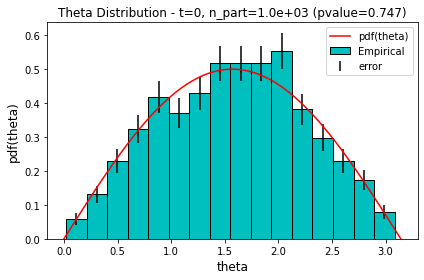

In [415]:
# Histogram Section #

# Generation of the normalized histogram and of the error bars
area = sum(np.diff(edges)*counts)
error = np.sqrt(counts) # Poissonian errors
bincenters = 0.5*(edges[1:]+edges[:-1])

normalized_counts_t, Bin_edges_t, hist_t = plt.hist(theta,bins='auto',range=None,density=True,color='c',edgecolor='black',label='Empirical')
error = error/area # the error bar must be rescaled since we normalized the histogram 
plt.errorbar(bincenters,normalized_counts_t,yerr=error,fmt='none',label='error',color='k')

## generation of the arrays containing some pdf's points
theta_pdf = np.empty(1000)
ascissa = np.linspace(0,math.pi,1000)
theta_pdf = pdf_t(ascissa)        
    
plt.plot(ascissa,theta_pdf,color='r',label='pdf(theta)')
plt.xlabel('theta',fontsize=12)
plt.ylabel('pdf(theta)',fontsize=12)
plt.title('Theta Distribution - t=0, n_part={:3.1e} (pvalue={:3.3})'.format(Nparticles,pvalue))
plt.legend()
plt.tight_layout()
plt.savefig('Theta_histo.jpg') 

In [416]:
## Density Distribution

In [417]:
# density function
def rho(r,b,M):
    return M*b/(2*math.pi*r*(r+b)**3)

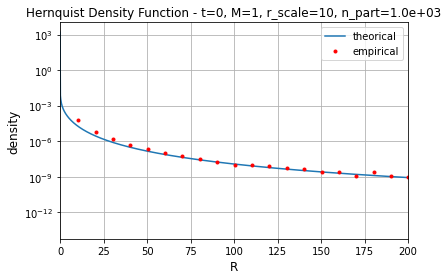

In [418]:
## generation of the theorical density
left_range = 0
right_range = r_scale*20
density = np.empty(1000)
ascissa = np.linspace(left_range+0.000001,right_range,1000) # '..+0.000001' because if left_range is = 0, density not defined
density = rho(ascissa,r_scale,M)  
plt.plot(ascissa,density,label='theorical')
plt.yscale('log')
## computation of the empirical density
counts, bin_edges = np.histogram(radius, bins='auto') # if you are not satisfied, choose 'bins' manually
system_density = []
for i in range(len(counts)):
    system_density.append(counts[i]*m/(4/3*math.pi*(bin_edges[i+1]**3-bin_edges[i]**3)))

plt.plot(bin_edges[1::],system_density,'r.',label='empirical')

plt.xlim(left_range,right_range)
plt.xlabel('R',fontsize=12)
plt.ylabel('density',fontsize=12)
plt.title('Hernquist Density Function - t=0, M={}, r_scale={}, n_part={:3.1e}'.format(M,r_scale,Nparticles))
plt.legend()
plt.grid()
plt.tight_layout()
plt.savefig('density_function.jpg') 
## N.B. in order to compute the error associated to the empirical density, one should use the error propagation
## In this case we decided to evaluate the accuracy qualitatively


In [419]:
# Note that the theorical density profile is heavily affected by the value of the scale radius.
# The generated distribution of particles do not follow very well the tail of the density profile since at big 
# radius the density goes to zero but your particles' mass is finite and positioning one of them at a big R will
# overstimate the density. Generating more particles, will decrease the mass of each particle (since they are equal
# mass) and traslate the density overstimation at a bigger R

In [420]:
###################################################################################################################

In [421]:
# The codes below were used to make some of the grapgh reported in the relation

In [ ]:
'''
plt.plot(eps_sliced_part,particle_pdf,label='From numerical integration',marker='x',color='k')
xnew = np.linspace(0, particle_relPot, 100)
ynew = interpolate.splev(xnew, spline_data, der=0)
plt.plot(xnew,ynew,label='Spline interpolation')
plt.xlabel('eps',fontsize=12)
plt.ylabel('f(eps)',fontsize=12)
plt.title('Distribution Function for one particle (not normalized)\n M_hern={}, M_BH={}, r_scale={}, n_part={:3.1e} \n integral_points={}'.format(M,M_BH,r_scale,Nparticles,k_points))
plt.grid()
plt.legend()
plt.tight_layout()
plt.savefig('Distribution_function_spline_oscillation.jpg')
'''

In [ ]:
'''
plt.plot(v_sliced,particle_cdf)
plt.xlabel('|v|',fontsize=12)
plt.ylabel('cdf(v)',fontsize=12)
plt.axvline(v_max,label='Vel_max',c='k',ls=':')
plt.title('Velocity cdf for one particle')
plt.grid()
plt.legend()
plt.tight_layout()
plt.savefig('cdf.jpg')
'''

In [ ]:
'''
xnew = np.linspace(0, 1, 1000)
ynew = interpolate.splev(xnew, spline_data_cdf, der=0)
plt.ylabel('|v|',fontsize=12)
plt.xlabel('cdf(v)',fontsize=12)
plt.axhline(v_max,label='Vel_max',c='k',ls=':')
plt.title('Inverse of the cdf')
plt.grid()
plt.legend()
plt.tight_layout()
plt.plot(xnew,ynew)
plt.savefig('cdf_inverse.jpg')
'''